In [2]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [3]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

In [5]:
data = torch.tensor( iris[iris.columns[0:4]].values ).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [7]:
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

train_dataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataset  = torch.utils.data.TensorDataset(test_data,test_labels)

train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [15]:
L2_lambda = .01

In [16]:
def create_model(L2_lambda):

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  loss_fun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,weight_decay=L2_lambda)

  return ANNiris,loss_fun,optimizer

In [34]:
ANNiris,loss_fun,optimizer = create_model(L2_lambda)

In [35]:
epochs = 1000

def train_model():

  train_acc = []
  test_acc  = []
  losses   = []

  for i in range(epochs):
    ANNiris.train() 

    batch_acc  = []
    batch_loss = []
    for X,y in train_loader:

      y_hat = ANNiris(X)
      loss = loss_fun(y_hat,y)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100*torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item() )
      batch_loss.append( loss.item() )

    train_acc.append( np.mean(batch_acc) )
    losses.append( np.mean(batch_loss) )

    ANNiris.eval()
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(ANNiris(X),axis=1)
    test_acc.append( 100*torch.mean((pred_labels == y).float()).item() )
  
  return train_acc,test_acc,losses


In [36]:
train_acc,test_acc,losses = train_model()

In [37]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

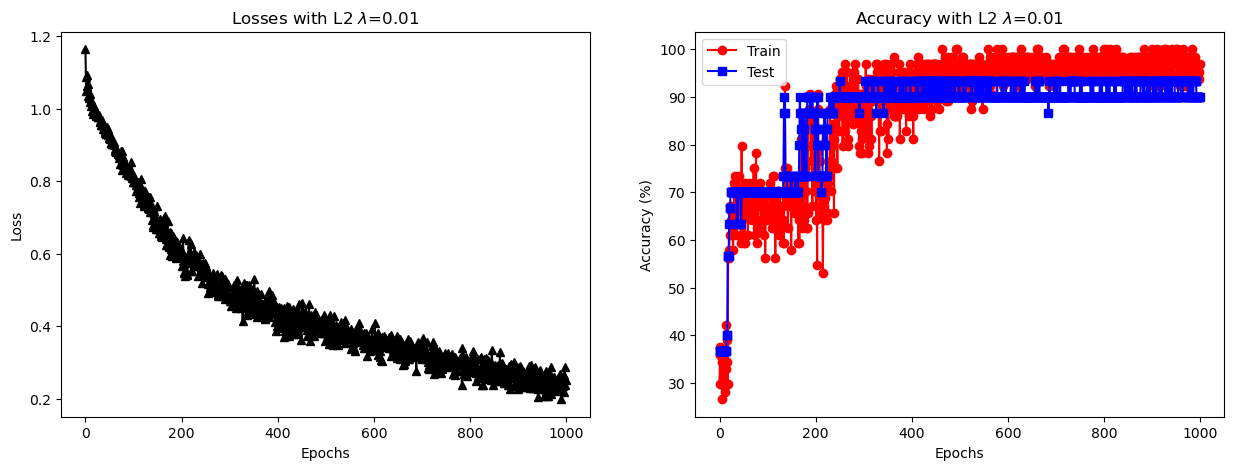

In [38]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2_lambda))

ax[1].plot(train_acc,'ro-')
ax[1].plot(test_acc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2_lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [39]:
l2lambdas = np.linspace(0,.1,10)

accuracy_train = np.zeros((epochs,len(l2lambdas)))
accuracy_test  = np.zeros((epochs,len(l2lambdas)))

for li in range(len(l2lambdas)):

  ANNiris,loss_fun,optimizer = create_model(l2lambdas[li])
  train_acc,test_acc,losses = train_model()

  accuracy_train[:,li] = smooth(train_acc,10)
  accuracy_test[:,li]  = smooth(test_acc,10)

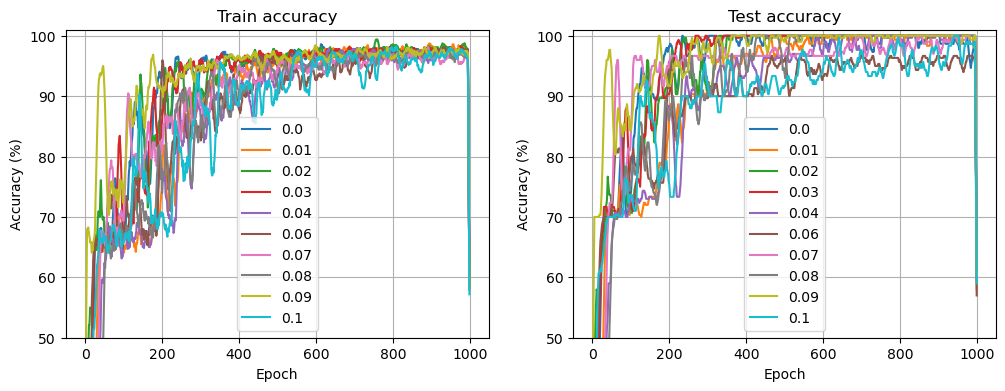

In [40]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(accuracy_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_test)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

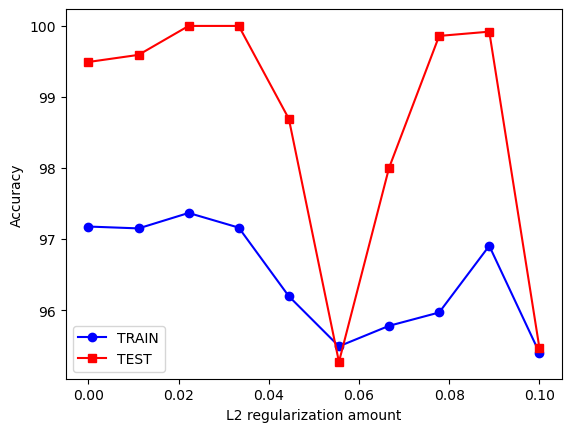

In [41]:
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracy_train[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracy_test[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()